# Assignment #5 - Artificial Neural Networks
---
## Name: 李勝維
## Student ID: 0711239
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
import warnings;warnings.filterwarnings("ignore")
%matplotlib inline
seed_everything(0)
plt.rcParams['figure.dpi'] = 200 # 500

Global seed set to 0


# Data Input & Data Visualization

Use package 'json' to read and 'pandas' to save data  

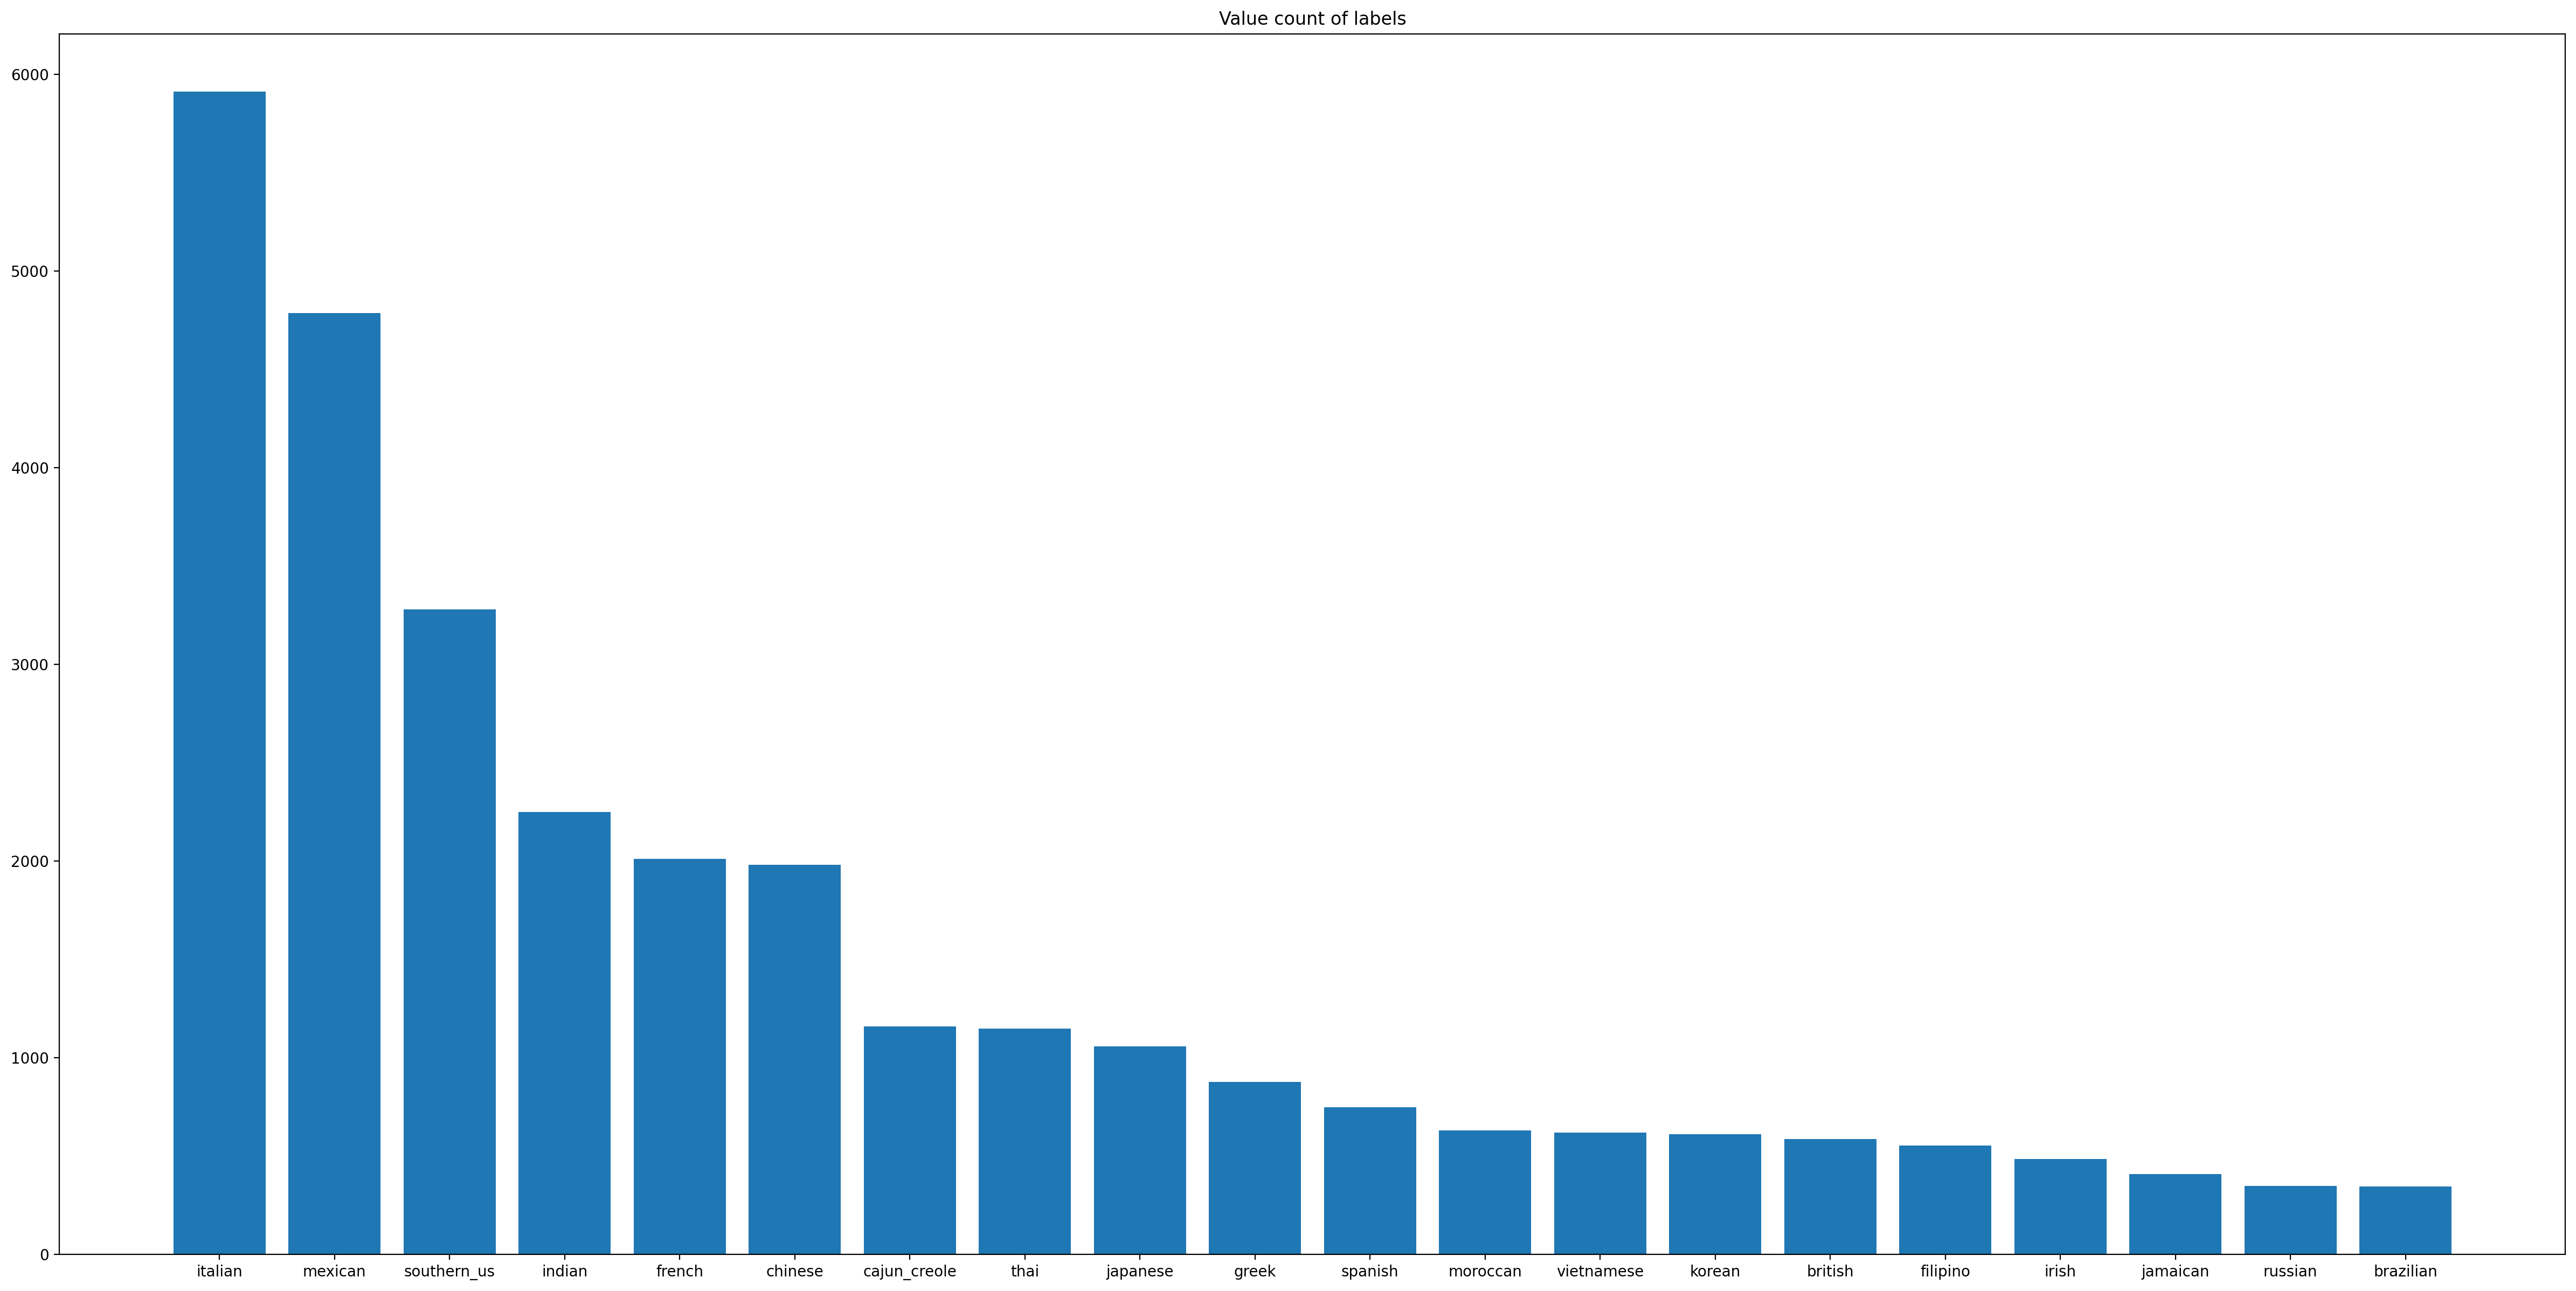

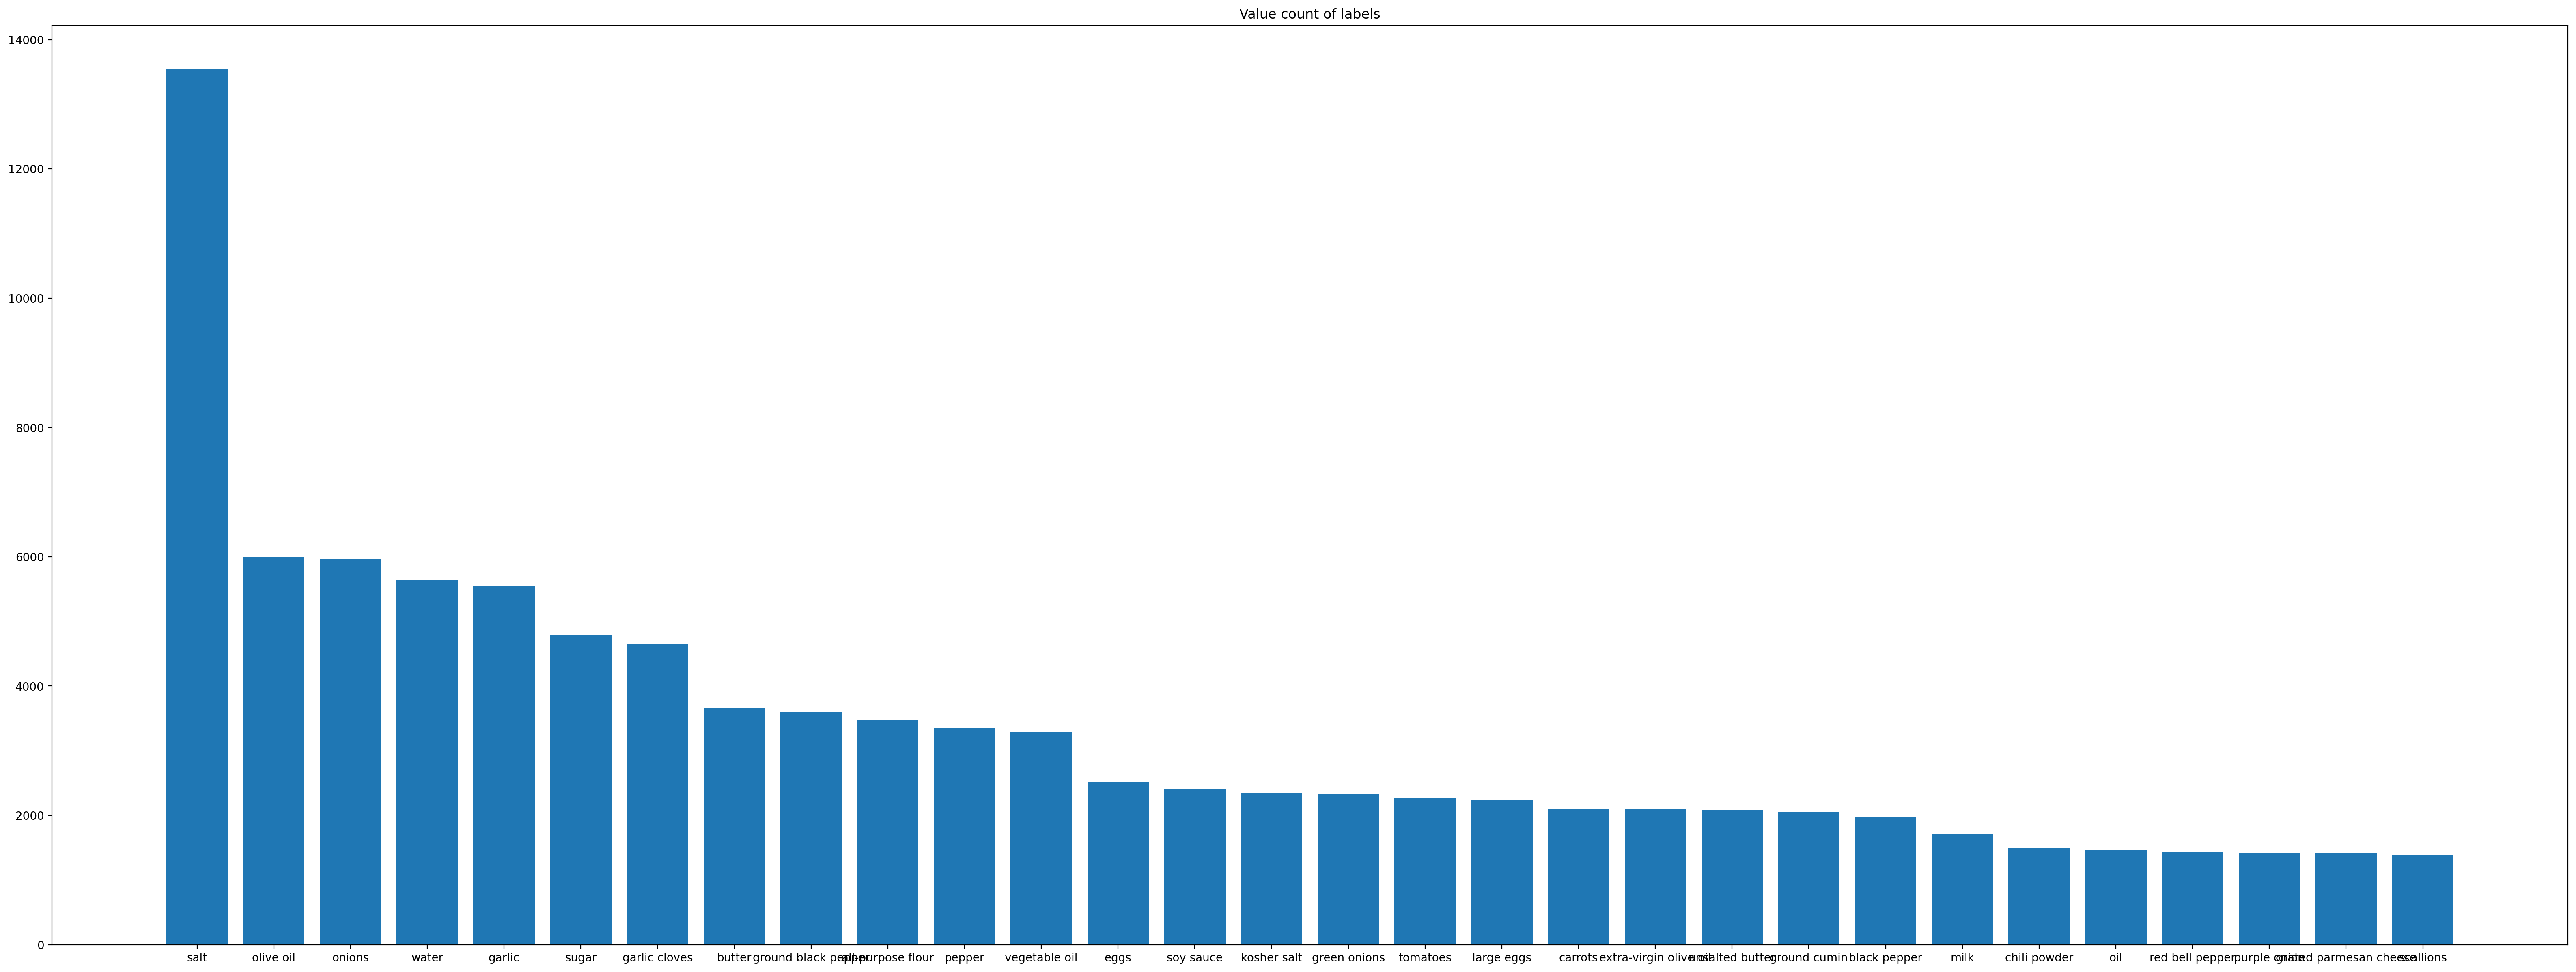

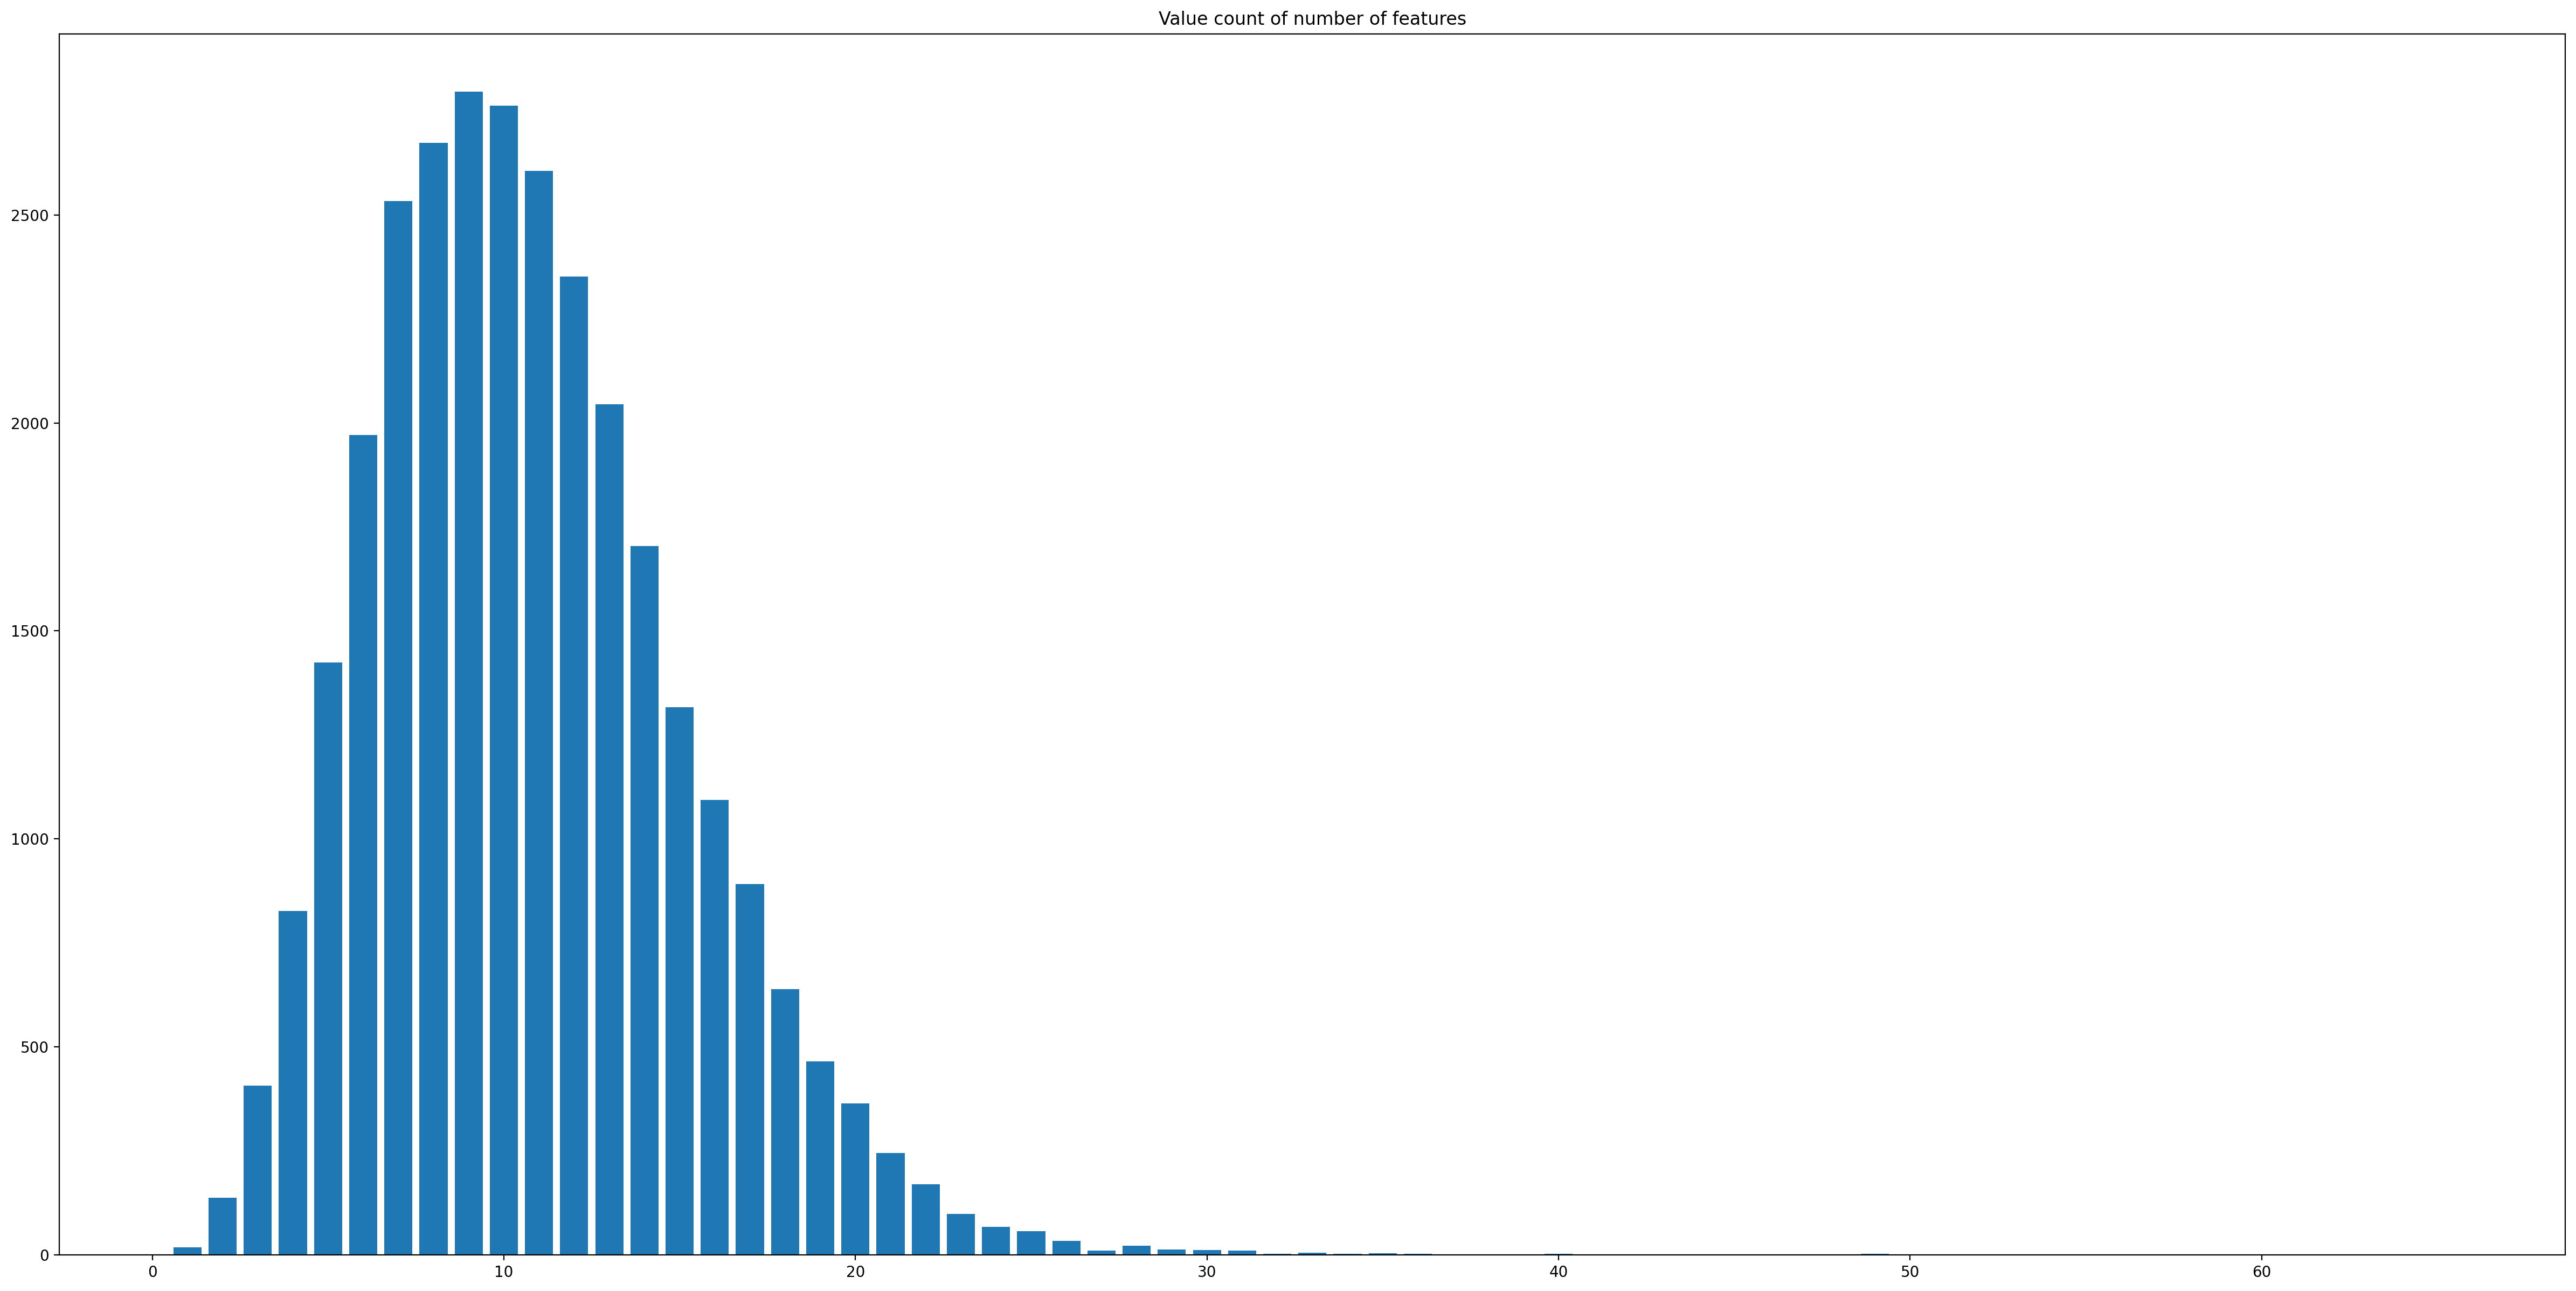

In [2]:
import json
from collections import defaultdict
# Data input
with open('2021-nycu-ml-hw5\\train.json', 'r') as file:
    raw_data = json.load(file)
raw_data = [(x['id'], x['cuisine'], x['ingredients']) for x in raw_data]
ids, cuisines, ingredientss = zip(*raw_data)
df = pd.DataFrame({
    'id':ids,
    'cuisine':cuisines,
    'ingredients':ingredientss,
})

# Data Visualization
# label
count = df['cuisine'].value_counts()
plt.figure(figsize=(30,15))
plt.title("Value count of labels")
plt.bar(count.index, height=count.values)
plt.show()

# features
count = defaultdict(lambda : 0)
for x in df['ingredients']:
    for n in x:
        count[n] += 1
# import pprint;pprint.pprint(count)
# get Top 30 features
count = {k: v for idx, (k, v) in enumerate(sorted(count.items(), key=lambda item: item[1], reverse=True)) if idx < 30}
count = pd.Series(count)
plt.figure(figsize=(40,15))
plt.title("Value count of labels")
plt.bar(count.index, height=count.values)
plt.show()

# number of ingredients
count = defaultdict(lambda : 0)
for x in df['ingredients']:
    count[len(x)] += 1
count = {k: v for (k, v) in sorted(count.items(), key=lambda item: item[1], reverse=True)}
count = pd.Series(count)
plt.figure(figsize=(30,15))
plt.title("Value count of number of features")
plt.bar(count.index, height=count.values)
plt.show()

# Data Preprocessing

資料預處理步驟：
1. Shuffle  
2. 去除 'stop words' (EX: the, any, then ...) 沒意義的單字
3. 轉成小寫 (不區分大小寫)
4. 使用 Porter Stemmer 演算法去除單字變化 (EX: 單複數變化)
5. 最後計算 TF-IDF 矩陣來取代 one-hot encoding

In [3]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def Porter_Stemmer(s):
    PS = PorterStemmer()
    stop_words = stopwords.words('english')
    str = ' '.join([PS.stem(w.lower()) for w in s if w not in stop_words])
    return str


# Shuffle data
df = df.sample(frac=1, random_state=0)

# Porter Stemmer
df['concat'] = [Porter_Stemmer(s) for s in df['ingredients']]

# Transform into TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['concat']).toarray().astype(np.float32)
# Encode Y
y_encoder = LabelEncoder()
df['cuisine'] = y_encoder.fit_transform(df['cuisine'])
y = df['cuisine'].values.astype(np.longlong)

# Artificial Neural Networks
## Reasoning of model choice:
選擇MLP來做只是因為它實作最快，效果也有保證，多次實驗不同的架構/有無batch norm/有無dropout後，選擇只有兩層的架構，因為訓練資料不夠多，參數量少一點比較好

## Data augmentation
無

## Training process
MLP的輸出層有20個node，和label種類相同，直接使用cross entropy作為loss function進行訓練

In [4]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split

class MLP(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        # self.clf = nn.Sequential(
        #     nn.Linear(2809, 4096),
        #     nn.LeakyReLU(0.2),
        #     nn.BatchNorm1d(4096),
        #     nn.Dropout(),

        #     nn.Linear(4096, 2048),
        #     nn.LeakyReLU(0.2),
        #     nn.BatchNorm1d(2048),
        #     nn.Dropout(),

        #     nn.Linear(2048, 1024),
        #     nn.LeakyReLU(0.2),
        #     nn.BatchNorm1d(1024),
        #     nn.Dropout(),

        #     nn.Linear(1024, 20),
        # )
        self.clf = nn.Sequential(
            nn.Linear(2809, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Dropout(),

            nn.Linear(512, 20),
        )
        self.criterion = nn.functional.cross_entropy

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(next(iter(self.parameters())).device)
        rst = self.clf(x)
        return torch.argmax(rst, 1).cpu().numpy()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.clf(x)
        loss = self.criterion(y_pred, y)
        self.log('Training_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        rst = self.clf(x)
        loss = self.criterion(rst, y)
        self.log('acc_loss', loss)
        y_pred = torch.argmax(rst, 1)
        acc = (y_pred.cpu().numpy() == y.cpu().numpy()).mean()
        self.log('Acc', acc)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Holdout split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

train_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valid_set = TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid))
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False, drop_last=False)

checkpoint_callback = ModelCheckpoint(
    monitor="Acc",
    dirpath="weights",
    filename="{epoch:d}-{Acc:.6f}",
    save_top_k=1,
    mode="max",
)
ES_callback = EarlyStopping(monitor='Acc', mode='max')

model = MLP()
trainer = pl.Trainer(gpus=-1, callbacks=[checkpoint_callback, ES_callback], log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | clf  | Sequential | 1.5 M 
------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.800     Total estimated model params size (MB)


Global seed set to 0


Epoch 5: 100%|██████████| 22/22 [00:00<00:00, 40.18it/s, loss=0.346, v_num=0]


# Validation Method
Note: 在前一節訓練時，即使用了 7:3 holdout 的切分，因此此節之間載入訓練好的權重進行計算

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

# load best model weight
model = MLP.load_from_checkpoint(checkpoint_callback.best_model_path).eval()

# shows metrics for each class
def show_multiclass_score(y_pred, y_test, y_label, silent=False):
    table_data = list()
    table_header = []
    accuracy = accuracy_score(y_test, y_pred)
    recalls = recall_score(y_test, y_pred, average=None)
    precisions = precision_score(y_test, y_pred, average=None)
    table_header = ['Label\Metrics', 'Accuracy', 'Recall', 'Precision']
    for name, recall, precision in zip(y_label, recalls, precisions):
        table_data.append([name,accuracy, recall, precision])
    if not silent:
        print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro')

# Results

In [6]:
from IPython.display import display, Latex
from pprint import pprint

# Multi-class
y_pred = model(X_valid)
print('Multi-class metrics: ')
acc, recall, pres = show_multiclass_score(y_pred, y_valid, y_encoder.classes_)
display(Latex(f"$Accuracy = {acc:4f},\ Average\ recall = {recall:4f},\ Average\ precision = {pres:4f}$"))

# Confusion matrix
print('y transform =\n')
pprint(dict(enumerate(y_encoder.classes_, 1)))
print('\nConfusion matrix:')
c_m = confusion_matrix(y_valid, y_pred)
table_data = list()
table_header = ['No.'] + list(range(1, 21))# list(y_encoder.classes_)
for idx, row in enumerate(c_m):
    table_data.append([table_header[idx+1], *row])
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

Multi-class metrics: 
╒═════════════════╤════════════╤══════════╤═════════════╕
│ Label\Metrics   │   Accuracy │   Recall │   Precision │
╞═════════════════╪════════════╪══════════╪═════════════╡
│ brazilian       │   0.781932 │ 0.47     │    0.671429 │
├─────────────────┼────────────┼──────────┼─────────────┤
│ british         │   0.781932 │ 0.417647 │    0.617391 │
├─────────────────┼────────────┼──────────┼─────────────┤
│ cajun_creole    │   0.781932 │ 0.667575 │    0.76087  │
├─────────────────┼────────────┼──────────┼─────────────┤
│ chinese         │   0.781932 │ 0.841584 │    0.794393 │
├─────────────────┼────────────┼──────────┼─────────────┤
│ filipino        │   0.781932 │ 0.511628 │    0.671756 │
├─────────────────┼────────────┼──────────┼─────────────┤
│ french          │   0.781932 │ 0.614357 │    0.631218 │
├─────────────────┼────────────┼──────────┼─────────────┤
│ greek           │   0.781932 │ 0.708861 │    0.785047 │
├─────────────────┼────────────┼──────────┼───────

<IPython.core.display.Latex object>

y transform =

{1: 'brazilian',
 2: 'british',
 3: 'cajun_creole',
 4: 'chinese',
 5: 'filipino',
 6: 'french',
 7: 'greek',
 8: 'indian',
 9: 'irish',
 10: 'italian',
 11: 'jamaican',
 12: 'japanese',
 13: 'korean',
 14: 'mexican',
 15: 'moroccan',
 16: 'russian',
 17: 'southern_us',
 18: 'spanish',
 19: 'thai',
 20: 'vietnamese'}

Confusion matrix:
╒═══════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│   No. │   1 │   2 │   3 │   4 │   5 │   6 │   7 │   8 │   9 │   10 │   11 │   12 │   13 │   14 │   15 │   16 │   17 │   18 │   19 │   20 │
╞═══════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│     1 │  47 │   1 │   1 │   0 │   4 │   2 │   0 │   1 │   0 │    7 │    2 │    0 │    0 │   19 │    0 │    0 │    9 │    4 │    3 │    0 │
├───────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────┼──────┼──────

# Kaggle Submission
![alt leader board](Kaggle_leaderboard.png)

In [7]:
# Data input
with open('2021-nycu-ml-hw5\\test.json', 'r') as file:
    raw_data = json.load(file)
raw_data = [(x['id'], x['ingredients']) for x in raw_data]
ids, ingredientss = zip(*raw_data)
df = pd.DataFrame({
    'id':ids,
    'ingredients':ingredientss,
})

# load best model weight
model = MLP.load_from_checkpoint(checkpoint_callback.best_model_path).eval()

# Transform
df['concat'] = [Porter_Stemmer(s) for s in df['ingredients']] # Porter Stemmer
X = vectorizer.transform(df['concat']).toarray().astype(np.float32) # Transform into TF-IDF matrix

pred = model(X)
Category = y_encoder.inverse_transform(pred)

ans = pd.DataFrame({'id':ids, 'Category':Category})
print(ans.head())
ans.to_csv("my_submission.csv", index = False)

   id     Category
0  14      italian
1  22      mexican
2  24  southern_us
3  37      mexican
4  40  southern_us
